## MFE230T Deep Learning
Prajakta Chavan

### Methodology:
    1. Identified differnt useful features 
    2. Looked at correlation matrix
    3. Dropped few features based on correlation and lack of full-period data 
    4. Normalized the data
    6. Divided into train, validation and test data
    7. Built two benchamrk predictions and tested on validation data 
    8. Defined 4 different models
    9. Tain the model on train data
    9. Test accuarcy on test data
    10. Compare different models for errors and predcitions

In [41]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import SimpleRNN as RNN
from keras.optimizers import Adam
np.random.seed(1)

## Part1 - Data Processing

In [142]:
df = pd.read_csv("BTC_Daily_Data.csv")
df = df[:-1]
df["Price Volatility"] = df["Price Volatility"].fillna(0.0)
df = df.drop(["ETH_USD", "Ripple_USD", "Inflation Rate"], axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [160]:
display(df.head())

,Bitcoin Core (BTC) Price,Market Capitalization,Money Supply,Chain Value Density,Price Volatility,Daily Transactions,Transaction Value,Total Transactions,Miner Revenue,Hash Rate,Difficulty,Transaction Size,Output Volume,VIX Index,SPX Index,US 3MTH LIBOR
Date,,,,,,,,,,,,,,,,
2010-01-01,0.0,0.0,1624700.0,0.0,0.0,138.0,0.0,32713.0,6900.0,0.000008,1.0,136.0,0.00,21.68,1115.10,0.25063
2010-01-02,0.0,0.0,1631300.0,0.0,0.0,134.0,0.0,32847.0,6600.0,0.000008,1.0,136.0,100.00,21.68,1115.10,0.25063
2010-01-03,0.0,0.0,1637600.0,0.0,0.0,126.0,0.0,32973.0,6300.0,0.000007,1.0,136.0,0.00,21.68,1115.10,0.25063
2010-01-04,0.0,0.0,1646900.0,0.0,0.0,186.0,0.0,33159.0,9300.0,0.000007,1.0,136.0,0.00,20.04,1132.98,0.25438
2010-01-05,0.0,0.0,1655950.0,0.0,0.0,183.0,0.0,33342.0,9050.0,0.000008,1.0,162.0,20804.35,19.35,1136.52,0.25250


In [161]:
print(df.columns)

Index(['Bitcoin Core (BTC) Price', 'Market Capitalization', 'Money Supply',
       'Chain Value Density', 'Price Volatility', 'Daily Transactions',
       'Transaction Value', 'Total Transactions', 'Miner Revenue', 'Hash Rate',
       'Difficulty', 'Transaction Size', 'Output Volume', 'VIX Index',
       'SPX Index', 'US 3MTH LIBOR'],
      dtype='object')


### Bitcoin Prices Plot

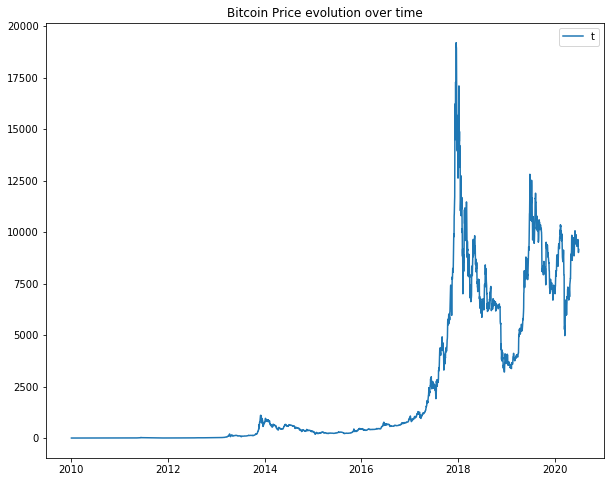

In [24]:
plt.figure(figsize=(10,8))
plt.plot(df['Bitcoin Core (BTC) Price'],label='BTC price')
plt.title('Bitcoin Price evolution over time')
plt.legend('top left')
plt.show()

## Normalize Data using Min Max Scaler

In [143]:
# standardizing data
feature_cols = ['Bitcoin Core (BTC) Price','Market Capitalization', 'Money Supply',
       'Chain Value Density', 'Price Volatility', 'Daily Transactions',
       'Transaction Value', 'Total Transactions', 'Miner Revenue', 'Hash Rate',
       'Difficulty', 'Transaction Size', 'Output Volume', 'VIX Index',
       'SPX Index', 'US 3MTH LIBOR']

scaled_cols = feature_cols
train_X_df = df[df.index<=dt.datetime(2019,6,30)]
train_X_df = train_X_df[scaled_cols]

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(train_X_df)

scaled_df = pd.DataFrame(scaled_df,columns=scaled_cols).round(5)
#scaled_df = df.copy()
#scaled_df[scaled_cols] = scaler.scaled_df[scaled_cols]

## Plot of individual features

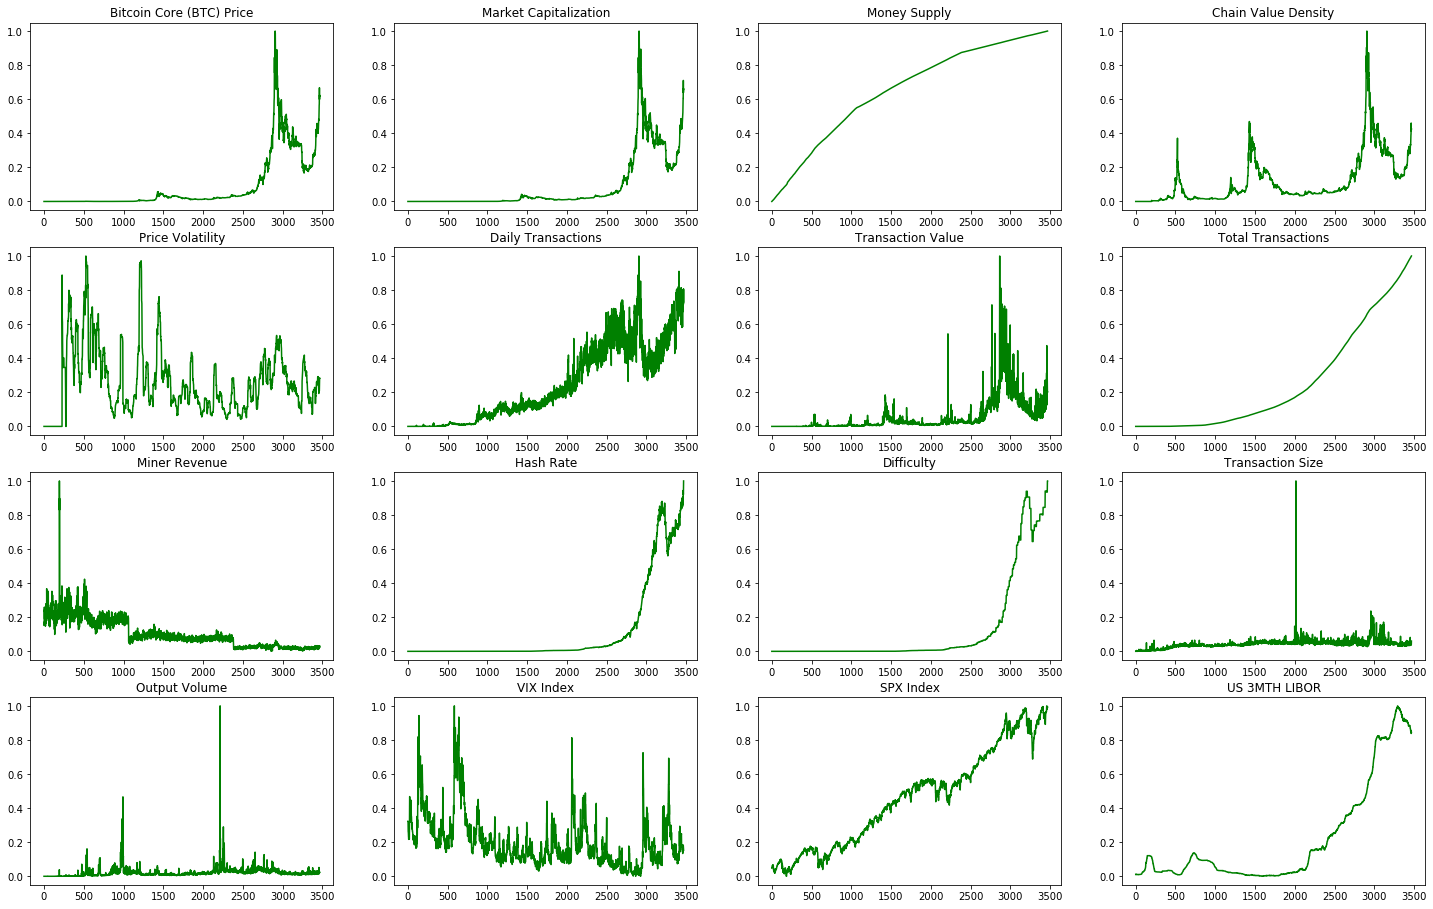

In [125]:
plt.figure(figsize=(25,20))
for i in range(len(scaled_df.columns)):
    plt.subplot(5,4,1+i)
    plt.plot(scaled_df.index, scaled_df.iloc[:,i],color='g')
    plt.title(scaled_df.columns[i])

## Correlation matrix 

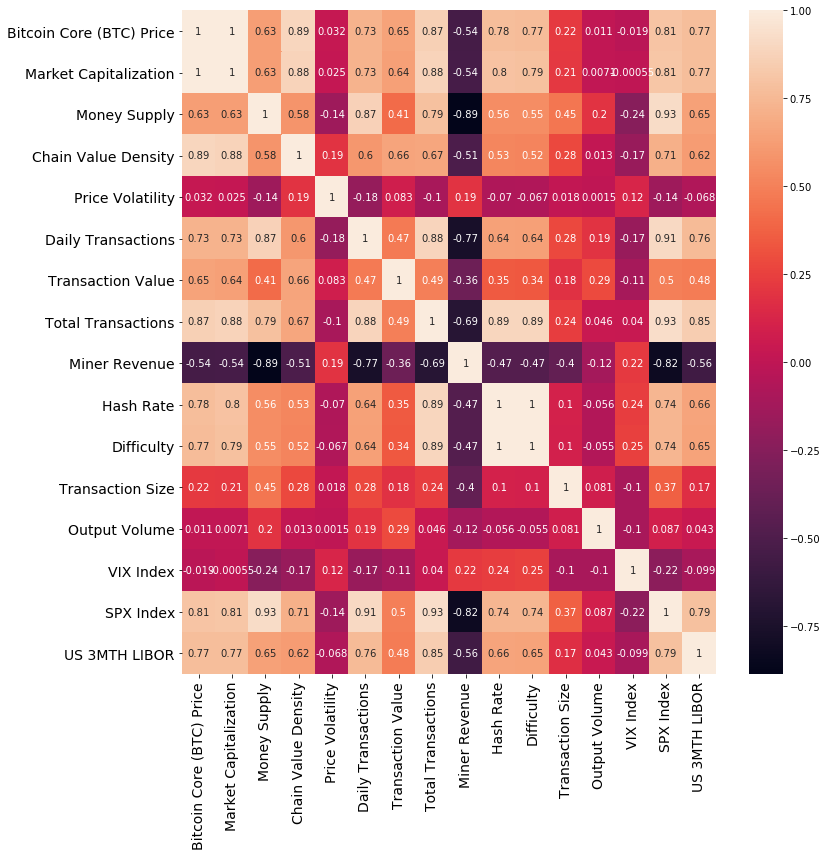

In [42]:
corr_matrix=scaled_df.corr(method='pearson')
plt.figure(figsize=(12,12))
sn.heatmap(corr_matrix, annot=True)
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()

## Observations

- Initially I had a total of 15 features, after observing the coorelation matrix and lack of data for full-period, I have dropped 3 features - Ripple, Etheruem, Inflation. invest in bitcoin when economy is growing 

- We can observe from the correlation matrix that Bitcoin prices are strongly correlated to the S&P500 Index and US 3-month Libor and inversely correlated with the Miner Revenue. This suggests that for 2010-2020 bitcoin prices and S&P500 almost moved together.Increase in S&P500 is reflection of economoy growing and high correlation with bitcoin indicates that when the economy is growing investors are more willing to invest into risk assets like Bitcoin.

- Miner Revenue decreases as Bitcoin Prices increase. Bitcoin prices are highly correlated with Hash Rate, Difficulty, Chain Value Density and moderately correlated Money Supply. Increase in bitcoin prices, increased the Hash Rate, Difficulty and Chain Value Density.

- Hash Rate and Difficulty are fully coorelated with each other and have same correlation with other features. Hence I dropped Difficulty as the correlation is captured by Hash Rate.

# Part 2 - Split Data into Train, Validation and Test set

In [8]:
#Function split data into look_back and target

def create_subseq(ts, look_back, pred_length):
    sub_seq, next_values = [], []
    for i in range(len(ts)-look_back-pred_length):  
        sub_seq.append(ts[i:i+look_back])
        next_values.append(ts[i+look_back:i+look_back+pred_length].T[0])
    sub_seq = np.array(sub_seq)
    next_values = np.array(next_values)
    return sub_seq, next_values

ts = scaled_df.values
look_back = 28
pred_length = 7
X,y = create_subseq(ts, look_back, pred_length)
X_flat = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
print(X.shape, y.shape)

(3799, 28, 16) (3799, 7)


In [9]:
date_idx = df.index[look_back+pred_length:].copy()
train_flag = date_idx<=dt.datetime(2019,6,30)
valid_flag = np.logical_and(date_idx>=dt.datetime(2019,7,1), date_idx<=dt.datetime(2019,12,31))
test_flag = np.logical_and(date_idx>=dt.datetime(2020,1,1), date_idx<=dt.datetime(2020,6,30))

#Split data into training, validation and test using the above flags
X_train = X[train_flag]
y_train = y[train_flag]
X_valid = X[valid_flag]
y_valid = y[valid_flag]
X_test = X[test_flag]
y_test = y[test_flag]

print(X_train.shape)

(3433, 28, 16)


In [10]:
#Flatten the feature data

X_train_flat = X_flat[train_flag]
X_valid_flat = X_flat[valid_flag]
X_test_flat = X_flat[test_flag]
print(X_train_flat.shape)

(3433, 448)


### 1. Benchmark Predictions on Validation Set

In [ ]:
We here intend to predict prices of validation set using two methods - 
1. Average of 28 lookback days to predict the next 7 target day prices
2. One Last price to predict the next 7 target day prices

In [ ]:
def cal_mae(y, yhat):
  return np.mean(np.abs(y - yhat))  

def cal_rsme(y, yhat):
  return np.sqrt(np.mean((y - yhat)**2))

Validation set RMSE: 0.05714232937602879
Validation set MAE: 0.04475063443289416


Text(0.5, 1.0, 'Validation set forecast')

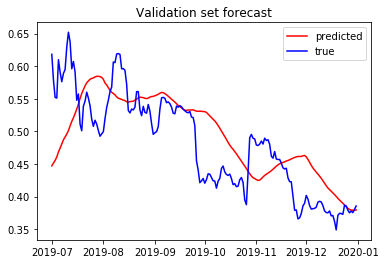

In [47]:
# Benchmmark Prediction - Using 28 lookback day average

ypred_benchmark1 = X_valid[:,:,0].copy().mean(axis=1)
y_pred = np.repeat(ypred_benchmark1.reshape(-1,1),repeats=7,axis=1)

mae = cal_mae(y_pred, y_valid)
rmse = cal_rsme(y_pred, y_valid)

print("Validation set RMSE:", rmse)
print("Validation set MAE:", mae)

#Plot Scaled bitcoin prices
plt.plot(date_idx[valid_flag], y_pred[:,-1], 'r')
plt.plot(date_idx[valid_flag], y_valid[:,-1], 'b')
plt.legend(["predicted", "true"])
plt.title("Validation set forecast")

- We can observe the first benchmark preditcion that takes the 28 average over lookback period, produces a smoothened output. The benchamrk prediction captures the voerall trend in prices but not the price fuctuations. 

Validation set RMSE: 0.034432818878868
Validation set MAE: 0.023970419177478636


Text(0.5, 1.0, 'Validation set forecast')

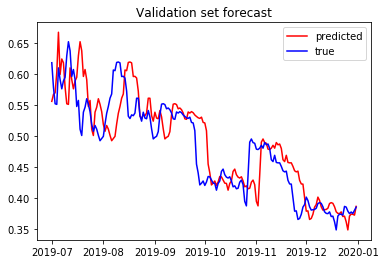

In [48]:
# Benchamrk Prediction - Using one last bitcoin price

ypred_benchmark2 = X_valid[:,-1,0].copy()
y_pred = np.repeat(ypred_benchmark2.reshape(-1,1),repeats=7,axis=1)
mae = cal_mae(y_pred, y_valid)
rmse = cal_rsme(y_pred, y_valid)

print("Validation set RMSE:", rmse)
print("Validation set MAE:", mae)

plt.plot(date_idx[valid_flag], y_pred[:,-1], 'r')
plt.plot(date_idx[valid_flag], y_valid[:,-1], 'b')
plt.legend(["predicted", "true"])
plt.title("Validation set forecast")

- The second benchmark prediction based on last price performs better on the validation set than the first one. The prediction better captures the price changes however it is lagging the original data.

# Training Neural Networks

### Define models 

In [68]:
def build_SimpleNN_2(units_num, input_shape):
    model = Sequential()
    dim = input_shape[0]*input_shape[1]
    model.add(Dense(units_num, input_dim=dim, activation='relu'))
    model.add(Dense(7))

    model.compile(loss='mae', optimizer='adam')
    
    return model


def build_LSTM_model_3(units_num, input_shape, activation='tanh', opt='adam'):
    model = Sequential()
    model.add(LSTM(units_num, input_shape=input_shape, activation=activation))
    model.add(Dense(7))
    model.compile(loss='mae', optimizer=opt)
    
    return model

def build_GRU_model_4(units_num, input_shape, activation='relu'):
    model = Sequential()
    model.add(GRU(units_num, input_shape=input_shape, activation=activation))
    model.add(Dense(7))
    model.compile(loss='mae', optimizer='adam')
    
    return model


def build_GRU_model_5(units_num, input_shape, dropout_rate=0.2, activation='sigmoid'):
    model = Sequential()
    model.add(GRU(units_num, input_shape=input_shape, activation=activation, recurrent_dropout=dropout_rate))
    model.add(Dense(7))
    model.compile(loss='huber', optimizer='RMSprop')
    
    return model


def build_GRU_model_6(units_num, input_shape, dropout_rate=0.2, activation='tanh'):
   model = Sequential()
   model.add(GRU(units_num, input_shape=input_shape, activation=activation, recurrent_dropout=dropout_rate, dropout=dropout_rate, return_sequences=True))
   model.add(GRU(units_num//2, activation=activation, recurrent_dropout=dropout_rate, dropout=dropout_rate))
   model.add(Dense(7))
   model.compile(loss='mae', optimizer='adam')
    
   return model


In [174]:
#Function to plot the training and validation loss
def plot_history_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs, loss, 'g', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()

#function to plot test set forecast
def eval_test(model, X_test, y_test):
  y_pred = model.predict(X_test)
  
  y_pred_inv = price_inverse(y_pred, pmin, pmax)
  y_test_inv = price_inverse(y_test, pmin, pmax)
  
  mae = cal_mae(y_pred, y_test)
  rmse = cal_rsme(y_pred, y_test)

  print("Test set RMSE:", rmse)
  print("Test set MAE:", mae)

  plt.plot(date_idx[test_flag], y_pred_inv[:,-1], 'b')
  plt.plot(date_idx[test_flag], y_test_inv[:,-1], 'r')
  plt.legend(["Predicted values", "True values"])
  plt.title("Inverse Scaled True Test set forecast")

# Function to rescale the scaled bitcoin prices
def price_inverse(series, pmin, pmax):
  inversed = series*(pmax - pmin) + pmin
  return inversed

pmin = np.min(train_X_df['Bitcoin Core (BTC) Price'])
pmax = np.max(train_X_df['Bitcoin Core (BTC) Price'])


def eval_test2(model, X_test, y_test):
  y_pred = model.predict(X_test)

  mae = cal_mae(y_pred, y_test)
  rmse = cal_rsme(y_pred, y_test)

  print("Test set RMSE:", rmse)
  print("Test set MAE:", mae)

## LSTM Model

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24)                3936      
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 175       
Total params: 4,111
Trainable params: 4,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
108/108 - 1s - loss: 0.0624 - val_loss: 0.2322
Epoch 2/50
108/108 - 1s - loss: 0.0580 - val_loss: 0.1531
Epoch 3/50
108/108 - 1s - loss: 0.0426 - val_loss: 0.1835
Epoch 4/50
108/108 - 1s - loss: 0.0426 - val_loss: 0.0734
Epoch 5/50
108/108 - 1s - loss: 0.0328 - val_loss: 0.1021
Epoch 6/50
108/108 - 1s - loss: 0.0336 - val_loss: 0.1218
Epoch 7/50
108/108 - 1s - loss: 0.0237 - val_loss: 0.0987
Epoch 8/50
108/108 - 1s - loss: 0.0216 - val_loss: 0.0863
Epoch 9/50
108/108 - 1s - loss: 0.0194 - val_loss

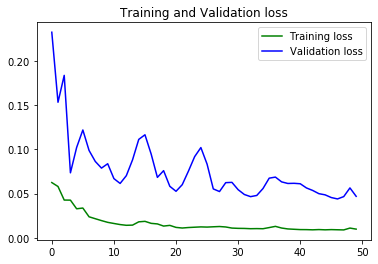

Test set rmse: 0.0700637098905865
Test set mae: 0.05579141158360151


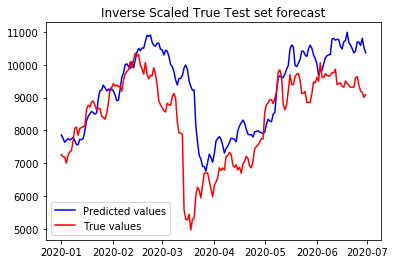

In [95]:
%%time
# LSTM
input_shape = (look_back, X_train.shape[2]) # n_timesteps, n_features
units_num = 24
epochs = 50
batch_size = 32

opt = 'adam'
LSTM_model = build_LSTM_model_3(units_num, input_shape, activation='relu', opt=opt)
LSTM_model.summary()

history_LSTM = LSTM_model.fit(X_train, y_train,
               epochs=epochs,
               batch_size=batch_size,
               shuffle=None,
               validation_data=(X_valid,y_valid),
               verbose=2)
plot_history_loss(history_LSTM)
eval_test(LSTM_model, X_test, y_test)

LSTM Model : activation =relu, optimizer = adam, loss function = mae, epochs = 50, batch size=32
    
   - We can observe that the training immediately drops to lower levels while the validation loss is still slower to decrease and fluctuates a bit
   - The gap between validation and training loss is decreasing with increasing epochs
   - The test set forecast captures the minor trends very well, but seems to miss the peaks

## Vanilla GRU

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 32)                4800      
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 231       
Total params: 5,031
Trainable params: 5,031
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
108/108 - 1s - loss: 0.0652 - val_loss: 0.1844
Epoch 2/50
108/108 - 1s - loss: 0.0616 - val_loss: 0.1229
Epoch 3/50
108/108 - 1s - loss: 0.0384 - val_loss: 0.1189
Epoch 4/50
108/108 - 1s - loss: 0.0357 - val_loss: 0.0795
Epoch 5/50
108/108 - 1s - loss: 0.0268 - val_loss: 0.0730
Epoch 6/50
108/108 - 1s - loss: 0.0249 - val_loss: 0.0899
Epoch 7/50
108/108 - 1s - loss: 0.0232 - val_loss: 0.1053
Epoch 8/50
108/108 - 1s - loss: 0.0207 - val_loss: 0.0844
Epoch 9/50
108/108 - 1s - loss: 0.0192 - val_loss

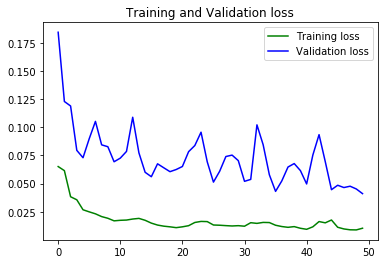

Test set rmse: 0.07575655916091023
Test set mae: 0.05927142925902562


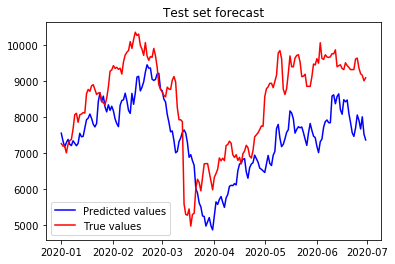

In [82]:
%%time
# Vanilla GRU
input_shape = (look_back, X_train.shape[2]) # n_timesteps, n_features
units_num = 32
# units_num = 24
epochs = 50
batch_size = 32

GRU_model_4 = build_GRU_model_4(units_num, input_shape, activation='relu')
GRU_model_4.summary()

history_GRU4 = GRU_model_4.fit(X_train, y_train,
               epochs=epochs,
               batch_size=batch_size,
               shuffle=None,
               validation_data=(X_valid,y_valid),
               verbose=2)
plot_history_loss(history_GRU4)
eval_test(GRU_model_4, X_test, y_test)

Vanilla GRU Model : activation =relu, optimizer = mae, loss function =adam, epochs = 50, batch size=32
    
   - We can observe that the training immediately drops to lower levels.
   - The validation loss is too drops quickly but fluctuates a bit
   - The gap between validation and training loss is decreasing with increasing epochs
   - The test set forecast captures the minor price trends with a delay. 
   - The forecast captures the peaks very well but misses the troughs

## GRU with recurrent dropout (layer 1)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_37 (GRU)                 (None, 32)                4800      
_________________________________________________________________
dense_37 (Dense)             (None, 7)                 231       
Total params: 5,031
Trainable params: 5,031
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
108/108 - 3s - loss: 0.0040 - val_loss: 0.0121
Epoch 2/50
108/108 - 2s - loss: 0.0034 - val_loss: 0.0076
Epoch 3/50
108/108 - 2s - loss: 0.0019 - val_loss: 0.0054
Epoch 4/50
108/108 - 2s - loss: 0.0013 - val_loss: 0.0039
Epoch 5/50
108/108 - 3s - loss: 9.1952e-04 - val_loss: 0.0043
Epoch 6/50
108/108 - 3s - loss: 6.8178e-04 - val_loss: 0.0052
Epoch 7/50
108/108 - 3s - loss: 5.5338e-04 - val_loss: 0.0054
Epoch 8/50
108/108 - 2s - loss: 4.9487e-04 - val_loss: 0.0055
Epoch 9/50
108/108 - 2s - loss: 4

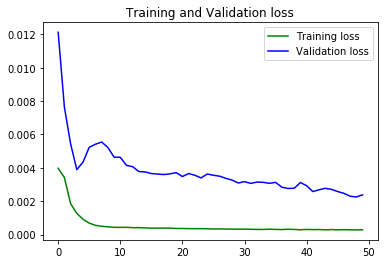

Test set RMSE: 0.08819728167336773
Test set MAE: 0.07119626809992374
Wall time: 1min 58s


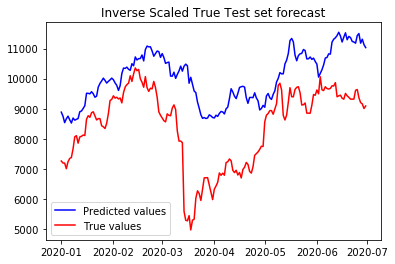

In [194]:
%%time
# GRU with reccurent dropout

input_shape = (look_back, X_train.shape[2]) # n_timesteps, n_features
units_num = 32
epochs = 50
batch_size = 32
dropout_rate = 0.2

GRU_model_5 = build_GRU_model_5(units_num, input_shape, dropout_rate, activation='relu')
GRU_model_5.summary()

history_GRU5 = GRU_model_5.fit(X_train, y_train,
               epochs=epochs,
               batch_size=batch_size,
               shuffle=None,
               validation_data=(X_valid,y_valid),
               verbose=2)
plot_history_loss(history_GRU5)
eval_test(GRU_model_5, X_test, y_test)

GRU with recurrent dropout Model : activation =sigmoid, optimizer = mae, loss function= huber, dropout =0.2, epochs = 50, batch size=32
    
   - We can observe that the training immediately drops to lower levels.
   - The validation loss is too drops quickly but fluctuates a lot indicating overfitting
   - The gap between validation and training loss is decreasing with increasing epochs
   - The test set forecast captures the minor price trends with a delay. 
   - The forecast captures the peaks very well but misses the troughs. 
   - The forecast is not very accurate during March 2020 which was the coronavirus crisis period when the stock and bitcoin prices fell sharply. 
   - We can say that the model does poorly during extreme/crisis events and good during non-crisis events

## GRU with recurrent dropout and dropout (2 layers)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_33 (GRU)                 (None, 28, 32)            4800      
_________________________________________________________________
gru_34 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_34 (Dense)             (None, 7)                 119       
Total params: 7,319
Trainable params: 7,319
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
108/108 - 6s - loss: 0.0672 - val_loss: 0.2339
Epoch 2/50
108/108 - 5s - loss: 0.0633 - val_loss: 0.1527
Epoch 3/50
108/108 - 5s - loss: 0.0490 - val_loss: 0.0962
Epoch 4/50
108/108 - 5s - loss: 0.0409 - val_loss: 0.0858
Epoch 5/50
108/108 - 5s - loss: 0.0327 - val_loss: 0.1012
Epoch 6/50
108/108 - 5s - loss: 0.0253 - val_loss: 0.1099
Epoch 7/50
108/108 - 5s - loss: 0

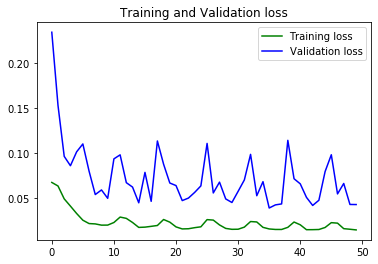

Test set RMSE: 0.050111630501337205
Test set MAE: 0.037509281279287016
Wall time: 4min 3s


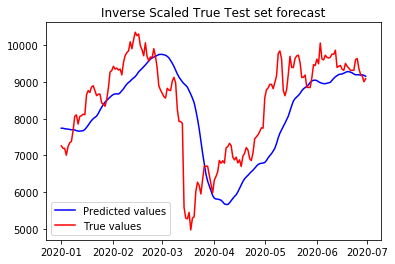

In [185]:
%%time
# 2 layer GRU with reccurent dropout and dropout

input_shape = (look_back, X_train.shape[2]) # n_timesteps, n_features
dropout_rate = 0.4
units_num = 32
epochs = 50
batch_size = 32

GRU_model_6 = build_GRU_model_6(units_num, input_shape, dropout_rate=dropout_rate, activation='relu')
GRU_model_6.summary()

history_GRU6 = GRU_model_6.fit(X_train, y_train,
               epochs=epochs,
               batch_size=batch_size,
               shuffle=None,
               validation_data=(X_valid,y_valid),
               verbose=2)
plot_history_loss(history_GRU6)
eval_test(GRU_model_6, X_test, y_test)

GRU with recurrent dropout and dropout Model (2 layers) : activation =relu, optimizer = adam, loss function = mae, dropout =0.4, epochs = 50, batch size=32

 - We can observe that the training immediately drops to lower levels.
 - The validation loss is too drops quickly but fluctuates a lot indicating overfitting
 - The gap between validation and training loss is decreasing with increasing epochs
 - The test set forecast captures the minor price trends with a delay. 
 - The forecast captures the peaks very well but misses the troughs. 
 - The forecast is not very accurate during March 2020 which was the coronavirus crisis period when the stock and bitcoin prices fell sharply. 
 - We can say that the model does poorly during extreme/crisis events and good during non-crisis events

## Simple Neural Network Model

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 528)               237072    
_________________________________________________________________
dense_27 (Dense)             (None, 7)                 3703      
Total params: 240,775
Trainable params: 240,775
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
108/108 - 0s - loss: 0.0935 - val_loss: 0.2616
Epoch 2/200
108/108 - 0s - loss: 0.0770 - val_loss: 0.2125
Epoch 3/200
108/108 - 0s - loss: 0.0575 - val_loss: 0.2681
Epoch 4/200
108/108 - 0s - loss: 0.0583 - val_loss: 0.3859
Epoch 5/200
108/108 - 0s - loss: 0.0562 - val_loss: 0.0998
Epoch 6/200
108/108 - 0s - loss: 0.0435 - val_loss: 0.2410
Epoch 7/200
108/108 - 0s - loss: 0.0419 - val_loss: 0.1467
Epoch 8/200
108/108 - 0s - loss: 0.0277 - val_loss: 0.1962
Epoch 9/200
108/108 - 0s - loss: 0.03

Epoch 127/200
108/108 - 0s - loss: 0.0177 - val_loss: 0.0829
Epoch 128/200
108/108 - 0s - loss: 0.0149 - val_loss: 0.0753
Epoch 129/200
108/108 - 0s - loss: 0.0130 - val_loss: 0.0481
Epoch 130/200
108/108 - 0s - loss: 0.0143 - val_loss: 0.1297
Epoch 131/200
108/108 - 0s - loss: 0.0162 - val_loss: 0.1162
Epoch 132/200
108/108 - 0s - loss: 0.0136 - val_loss: 0.1351
Epoch 133/200
108/108 - 0s - loss: 0.0138 - val_loss: 0.0983
Epoch 134/200
108/108 - 0s - loss: 0.0132 - val_loss: 0.1076
Epoch 135/200
108/108 - 0s - loss: 0.0119 - val_loss: 0.0764
Epoch 136/200
108/108 - 0s - loss: 0.0116 - val_loss: 0.0666
Epoch 137/200
108/108 - 0s - loss: 0.0122 - val_loss: 0.0462
Epoch 138/200
108/108 - 0s - loss: 0.0151 - val_loss: 0.1412
Epoch 139/200
108/108 - 0s - loss: 0.0288 - val_loss: 0.0646
Epoch 140/200
108/108 - 0s - loss: 0.0182 - val_loss: 0.0701
Epoch 141/200
108/108 - 0s - loss: 0.0136 - val_loss: 0.0782
Epoch 142/200
108/108 - 0s - loss: 0.0120 - val_loss: 0.0451
Epoch 143/200
108/108 - 

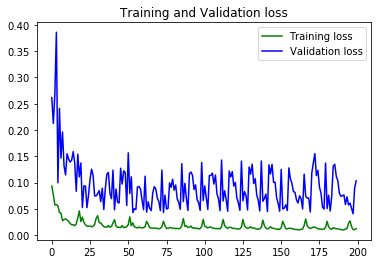

Test set rmse: 0.10062173116943383
Test set mae: 0.08493539034651791


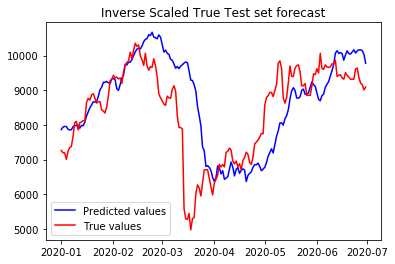

In [171]:
%%time
# Simple NN Model

input_shape = (look_back, X_train.shape[2]) # n_timesteps, n_features
units_num = 528
epochs = 200
batch_size = 32

SimpleNN_model = build_SimpleNN_2(units_num, input_shape)
SimpleNN_model.summary()

history_SimpleNN = SimpleNN_model.fit(X_train_flat, y_train,
               epochs=epochs,
               batch_size=batch_size,
               shuffle=None,
               validation_data=(X_valid_flat,y_valid),
               verbose=2)
plot_history_loss(history_SimpleNN)
eval_test(SimpleNN_model, X_test_flat, y_test)

Simple NN : activation= relu, loss function = mae, optimizer = adam, epochs = 200
   - The training and validation loss fluctuate a lot, although both quickly drop to lower levels.
   - The MAE and RMSE error is high as compared to other models.
   - The test set forecast is very por, it capture the trend and minor price fluctuations however misses the peaks and troughs

# Part 4 - Evaluate Results

Test set rmse: 1202.207958320446
Test set mae: 897.7046823839427


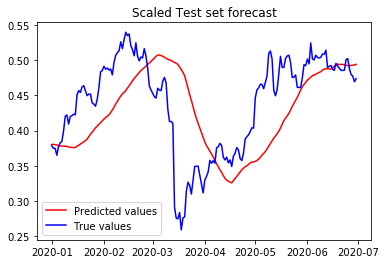

In [187]:
# Benchmark 1 - Predict average of 28 day lookback period

ypred_benchmark1 = X_test[:,:,0].copy().mean(axis=1)
y_pred = np.repeat(ypred_benchmark1.reshape(-1,1),repeats=7,axis=1)

y_pred_inv = price_inverse(y_pred, pmin, pmax)
y_test_inv = price_inverse(y_test, pmin, pmax)

mae = cal_mae(y_pred_inv, y_test_inv)
rmse = cal_rsme(y_pred_inv, y_test_inv)

print("Test set rmse:", rmse)
print("Test set mae:", mae)

#Plot Scaled test bitcoin prices
plt.plot(date_idx[test_flag], y_pred[:,-1], 'r')
plt.plot(date_idx[test_flag], y_test[:,-1], 'b')
plt.title("Scaled Test set forecast")
plt.legend(["Predicted values", "True values"])
plt.show()

#### The benchmark model using 28 day lookback average performs poorly on the test data. It captures the general trend but not the details. The prediction smoothens the past 28day values which does not give good result.

Text(0.5, 1.0, 'Benchmark Prediction 1 - Inverse Scaled True Test set forecast')

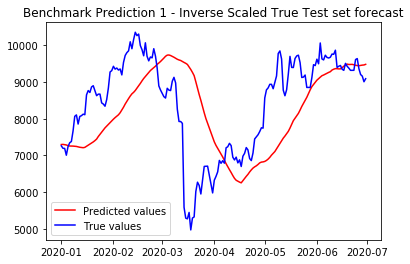

In [188]:
## Plot true Bitcoin prices
plt.plot(date_idx[test_flag], y_pred_inv[:,-1], 'r')
plt.plot(date_idx[test_flag], y_test_inv[:,-1], 'b')

plt.legend(["Predicted values", "True values"])
plt.title("Benchmark Prediction 1 - Inverse Scaled True Test set forecast")

#### The inverse scaled predicted values are very close to the true values of test data. It is a good forecast with a lag.

test set rmse: 0.03350812243595964
test set mae: 0.02199289634867522


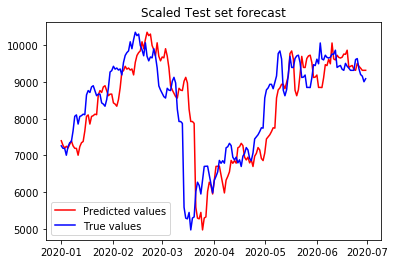

In [189]:
# Benchmark 2 - Using last price

ypred_benchmark2 = X_test[:,-1,0].copy()
y_pred = np.repeat(ypred_benchmark2.reshape(-1,1),repeats=7,axis=1)

y_pred_inv = price_inverse(y_pred, pmin, pmax)
y_test_inv = price_inverse(y_test, pmin, pmax)

mae = cal_mae(y_pred, y_test)
rmse = cal_rsme(y_pred, y_test)

print("test set rmse:", rmse)
print("test set mae:", mae)

#Plot Scaled bitcoin prices
plt.plot(date_idx[test_flag], y_pred_inv[:,-1], 'r')
plt.plot(date_idx[test_flag], y_test_inv[:,-1], 'b')
plt.title("Scaled Test set forecast")
plt.legend(["Predicted values", "True values"])
plt.show()

#### The benchmark prediction model based on last price does better than first model on test data. The predicted data performs well albeit with lagged prices

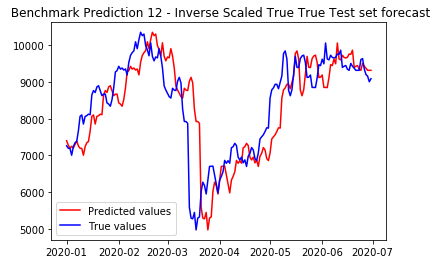

In [190]:
## Plot true Bitcoin prices
plt.plot(date_idx[test_flag], y_pred_inv[:,-1], 'r')
plt.plot(date_idx[test_flag], y_test_inv[:,-1], 'b')

plt.legend(["Predicted values", "True values"])
plt.title(" Benchmark Prediction 12 - Inverse Scaled True True Test set forecast")
plt.show()

#### The benchmark prediction model based on last price does better than first model on test data. The predicted data performs well albeit with lagged prices

### Compare all models 

In [195]:
# Print all evaluation results 

print("LSTM Model results:")
eval_test2(LSTM_model, X_test, y_test)
print()
print("Vanilla GRU model results: ")
eval_test2(GRU_model_4, X_test, y_test)
print()
print("GRU model (with recurrent dropout) results ")
eval_test2(GRU_model_5, X_test, y_test)
print()
print("GRU model (with recurrent dropout and dropout) results")
eval_test2(GRU_model_6, X_test, y_test)
print()
print("Simple NN Model results: ")
eval_test2(SimpleNN_model, X_test_flat, y_test)

LSTM Model results:
Test set RMSE: 0.0700637098905865
Test set MAE: 0.05579141158360151

Vanilla GRU model results: 
Test set RMSE: 0.07575655916091023
Test set MAE: 0.05927142925902562

GRU model (with recurrent dropout) results 
Test set RMSE: 0.08819728167336773
Test set MAE: 0.07119626809992374

GRU model (with recurrent dropout and dropout) results
Test set RMSE: 0.050111630501337205
Test set MAE: 0.037509281279287016

Simple NN Model results: 
Test set RMSE: 0.10062173116943383
Test set MAE: 0.08493539034651791


## Observations :

- From the above evaluation results, we can see that the RMSE and MAE error for GRU with two layers is the lowest, followed by LSTM model, Vanilla GRU and GRU with one layer.
- Simple NN has the highest RMSE and MAE error implying that the model might be overfitting.


### Model performance 

##### GRU with recurr. dropout and dropout 2 layers   >    LSTM   > Vanilla GRU  >  GRU with recurr. dropout (1 hidden layer)   >    Simple NN      

- Vanilla GRU works very well during extreme/crisis events like March-2020 coronavirus period. 
- LSTM and GRU with 2 layers show poor performance during the crisis period but perform better otherwise 

### Choice of parameters

Choice of Dropout rate = 0.2 (, 0.4 for GRU with 2 layers) tried other values for dropout and it increased the error

- Since dropout prevents overfitting, overreliance on any particular nodes in the hidden layer, so I have used a dropout randomly weights for some nodes during training.
- This helps to make our model more robust and improves out of sample performance.

Choice of Optimizer - Adam (, RMS prop for GRU with 1layer)
  - Choose this optimizer for most models because it a good first choice for most models and performs well with default paramters
  - My losses were most optimized using Adam optimizer. I tried RMSprop with different learning rates and momentum but it perform better than Adam optimizer


Choice of Activation - relu 

  - Tried tanh, relu, sigmoid activation for all the models
  - I observed relu performed the best given that ReLu has non-saturation of its gradient, which greatly accelerates the convergence of stochastic gradient descent compared to the sigmoid / tanh functions.